In [ ]:
%pip install -r requirements.txt

In [34]:
from cebra import CEBRA, KNNDecoder, L1LinearRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score


In [35]:
df = pd.read_hdf("data/ID18150/Day2/DataFrame_Imaging_dFF_18150_day2.h5")

In [36]:
# Get a list of columns whose names are of numerical type
numerical_columns = [col for col in df.columns if type(col) == int]

#Feature matrix
X = df[numerical_columns].values
t = df.Time.to_list()

In [37]:
delta = 5000
def get_x_ticks(L:int):
    x_ticks = np.arange(0,L,delta)
    x_tick_labels = [f"{t[i]/100:.2f}" for i in x_ticks]
    return x_ticks, x_tick_labels

In [38]:
split = int(0.2*len(X))
X_train, X_test = X[:-split], X[-split:]
y_train, y_test = df["Pump"].values[:-split], df["Pump"].values[-split:]
X_train.shape, X_test.shape

((52796, 709), (13198, 709))

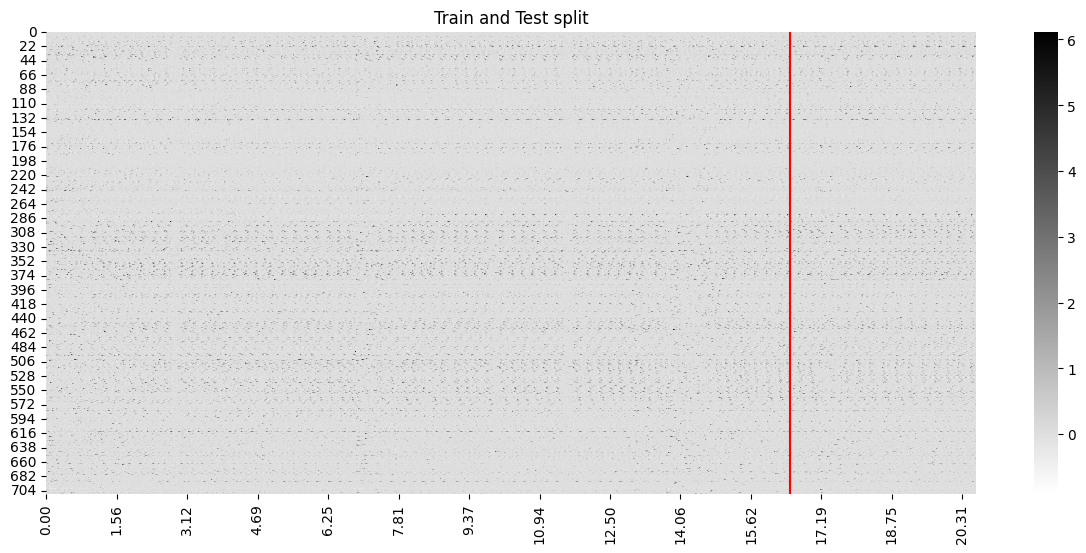

In [39]:
x_ticks, x_tick_labels = get_x_ticks(X.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax = sns.heatmap(X.T, ax=ax, cmap="gray_r")
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

v_bar = X_train.shape[0]
ax.axvline(v_bar, color="red")

ax.set_title("Train and Test split")

plt.show()

## CEBRA Time (Naive)

In [40]:
single_cebra_time = CEBRA(
    model_architecture="offset1-model",
    batch_size=512,
    output_dimension=8,
    device="cuda_if_available",
    conditional="time_delta",
    distance="cosine",
    learning_rate=3e-4,
    time_offsets=10,
    verbose=True
)
single_cebra_time.fit(X_train)
U_test = single_cebra_time.transform(X_test)
U_train = single_cebra_time.transform(X_train)

pos: -0.9958 neg:  6.9953 total:  5.9995 temperature:  1.0000: 100%|██████████| 10000/10000 [09:36<00:00, 17.35it/s]


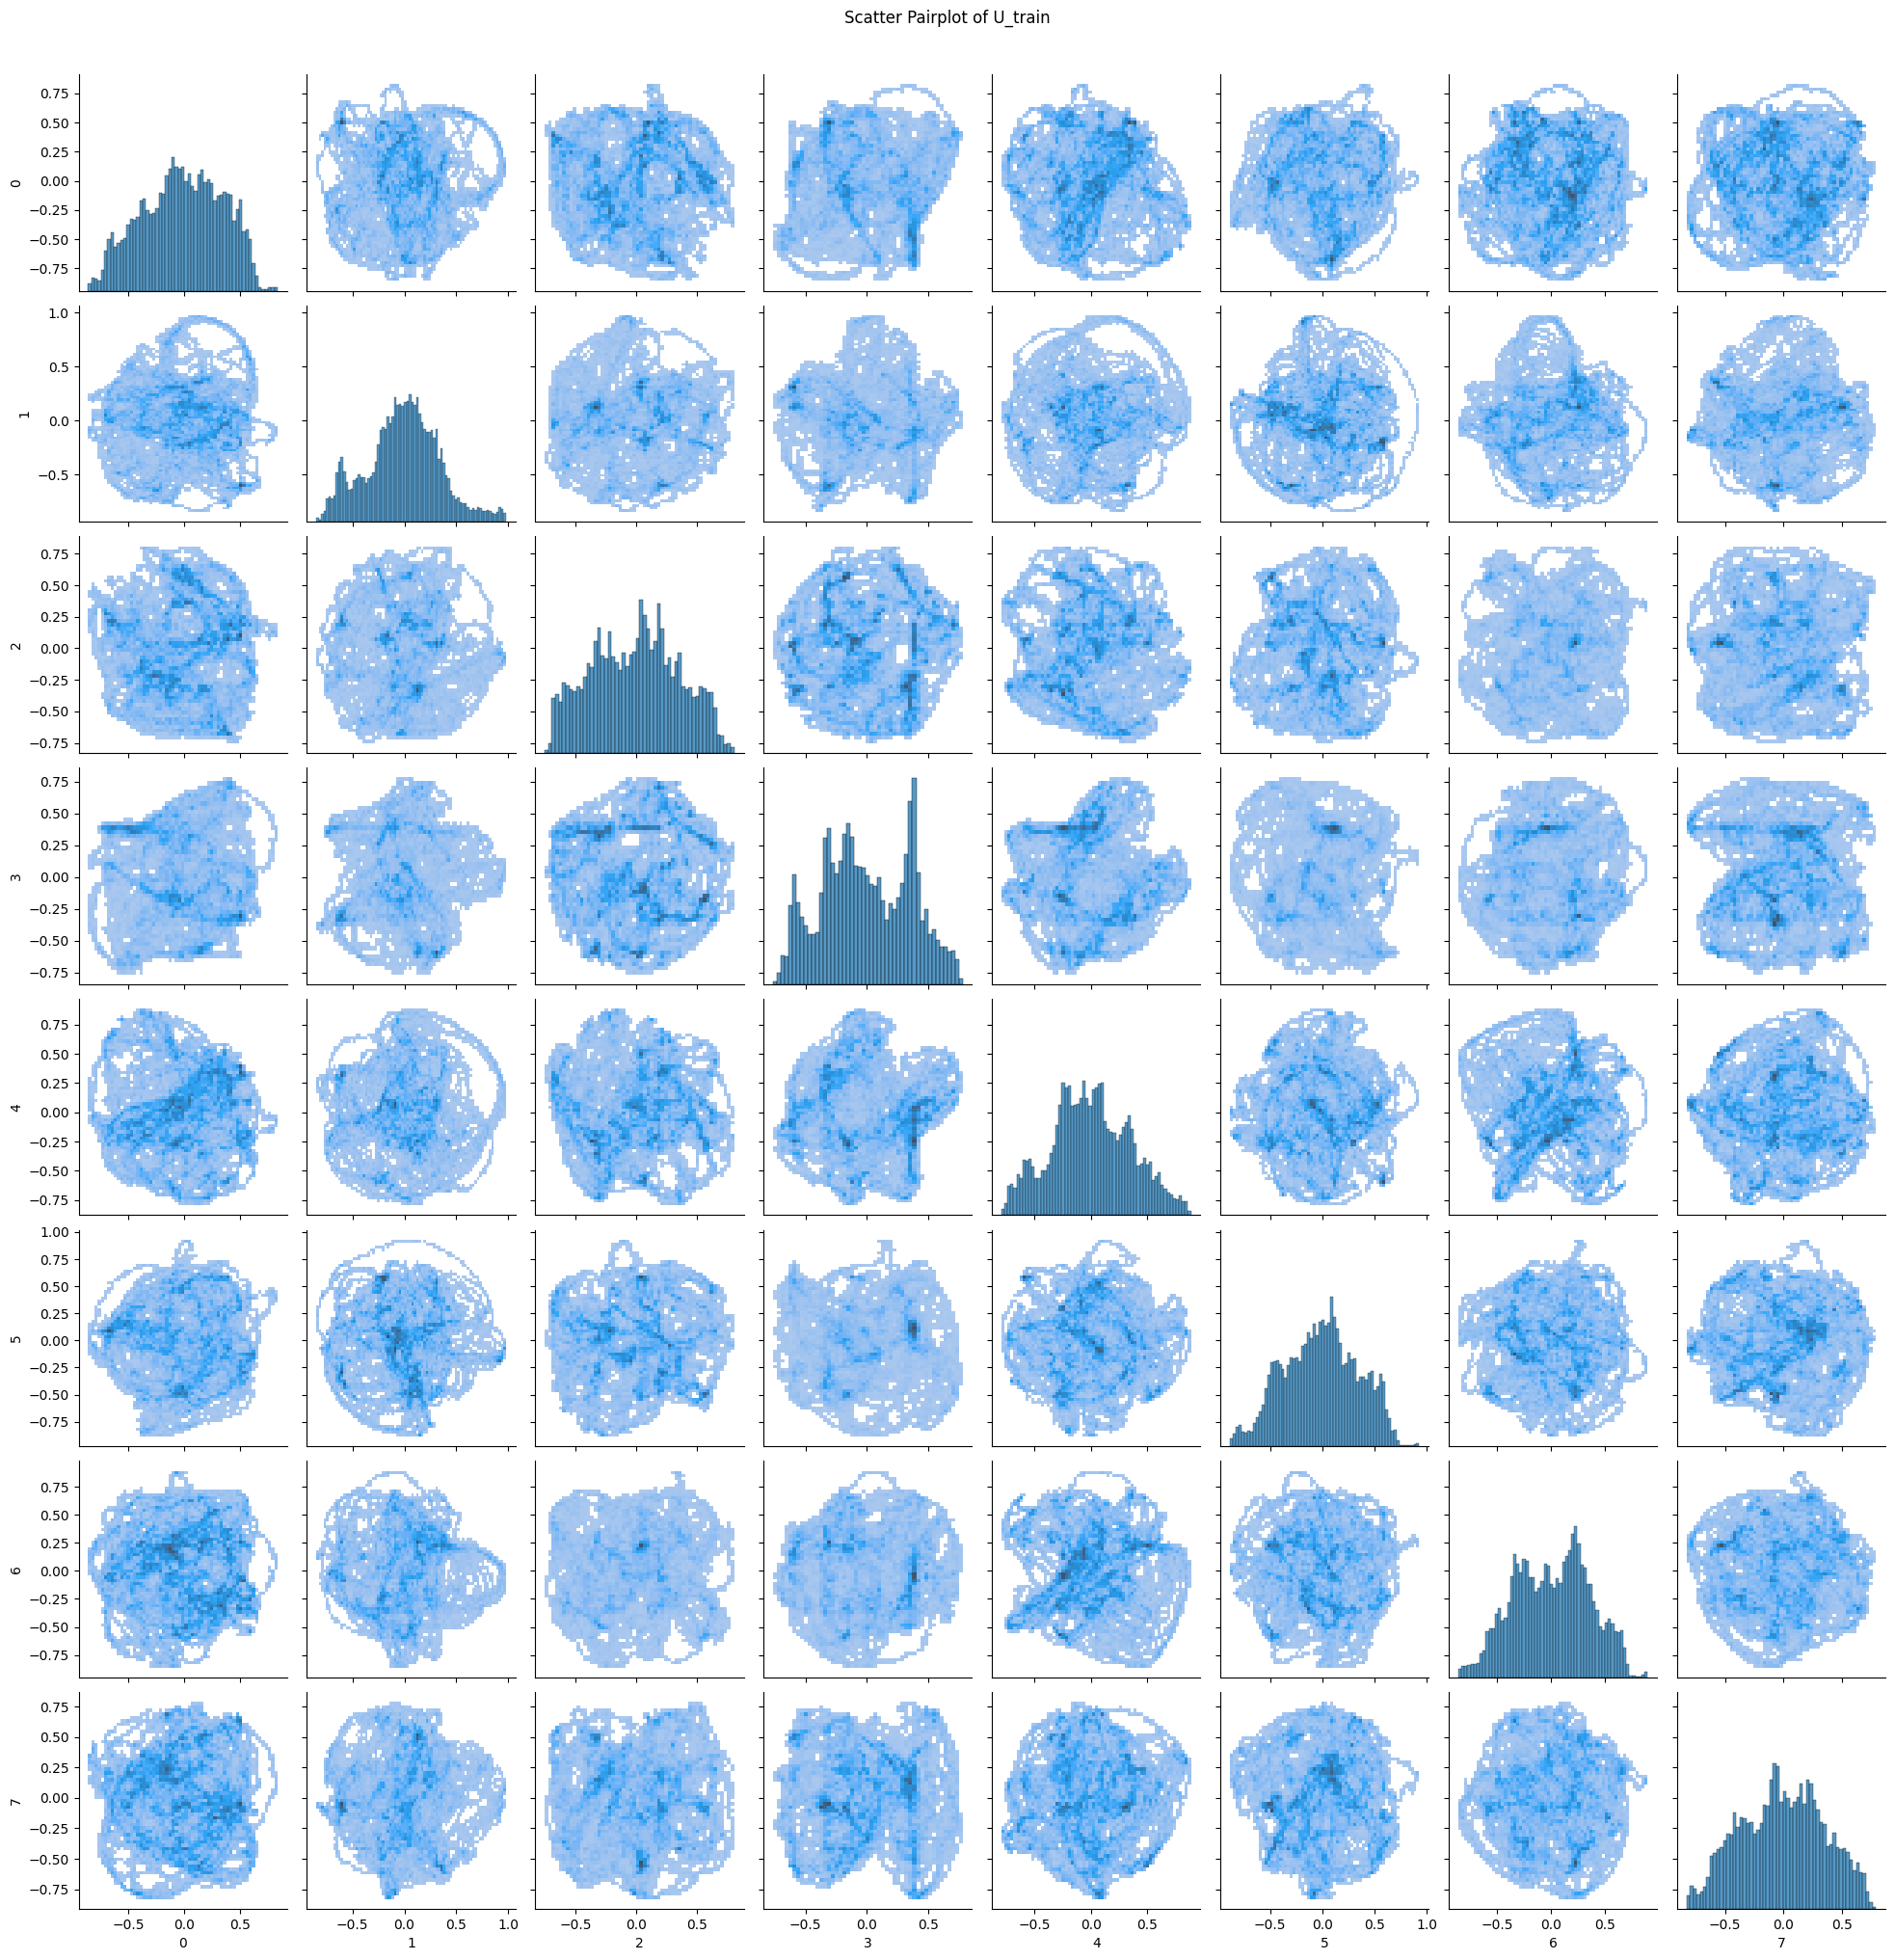

In [41]:
# Scatter pairplot of U_train
sns.pairplot(pd.DataFrame(U_train), kind="hist")
plt.suptitle('Scatter Pairplot of U_train', y=1.02)
plt.show()

In [42]:
decoder = KNNDecoder(n_neighbors=36, metric="cosine").fit(U_train, y_train)
y_pred = decoder.predict(U_test)
r2_score(y_test, y_pred)

0.00874549938252811

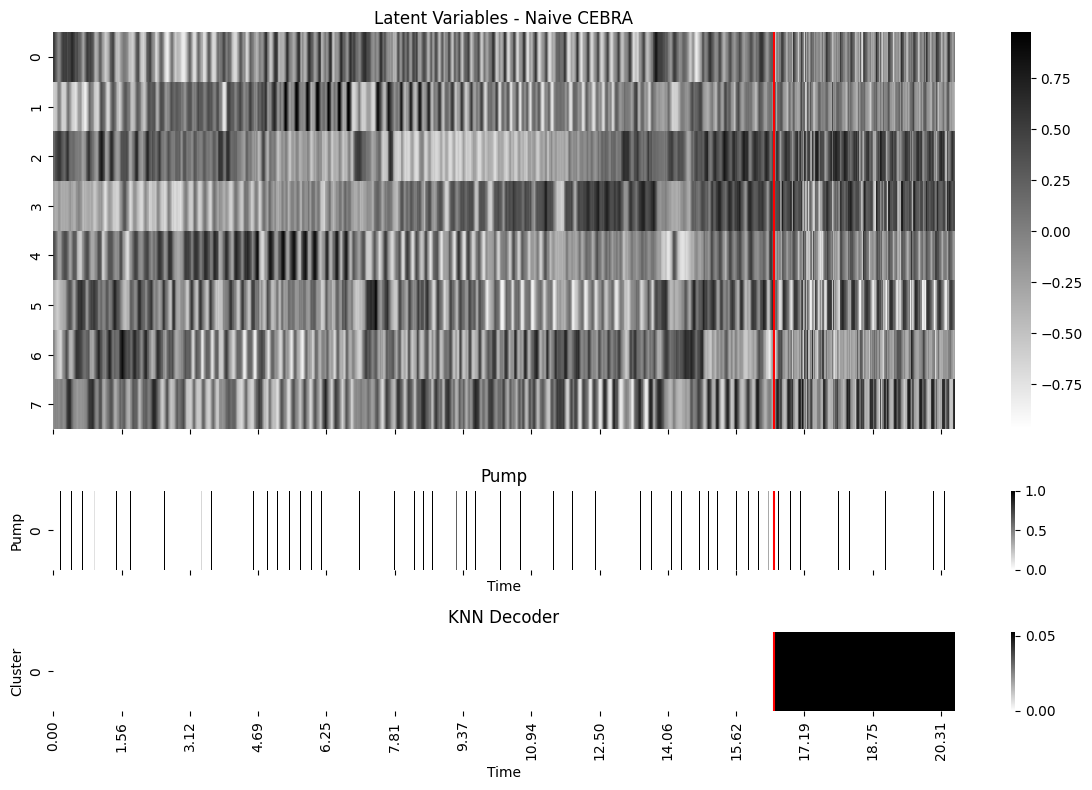

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [5, 1, 1]})

sns.heatmap(np.vstack([U_train,U_test]).T, ax=ax1, cmap='gray_r')
ax1.set_title('Latent Variables - Naive CEBRA')
ax1.set_xticks(x_ticks)
ax1.vlines(v_bar, 0, 16, color='red')

# Plot Pump data
sns.heatmap(df['Pump'].values.reshape(1, -1), ax=ax2, cmap='gray_r')
ax2.set_xlabel('Time')
ax2.set_ylabel('Pump')
ax2.set_title('Pump')
ax2.vlines(v_bar, 0, 1, color='red')
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels)

#Plot Kmeans classification over time
sns.heatmap(np.hstack([np.zeros(y_train.shape[0]), y_pred]).reshape(1,-1), ax=ax3, cmap='gray_r')
ax3.set_xlabel('Time')
ax3.set_ylabel('Cluster')
ax3.set_title('KNN Decoder')
ax3.vlines(v_bar, 0, 1, color='red')
ax3.set_xticks(x_ticks)
ax3.set_xticklabels(x_tick_labels)

plt.tight_layout()
plt.show()

## CEBRA Behavior (Pump as Continuous Label)

In [56]:
cebra = CEBRA(
    model_architecture="offset10-model",
    batch_size=1024,
    output_dimension=4,
    device="cuda_if_available",
    distance="cosine",
    conditional="time_delta",
    learning_rate=3e-4,
    time_offsets=10,
    verbose=True
)
cebra.fit(X_train, y_train)
U_test = cebra.transform(X_test)
U_train = cebra.transform(X_train)

pos: -0.6522 neg:  7.3156 total:  6.6634 temperature:  1.0000: 100%|██████████| 10000/10000 [10:30<00:00, 15.85it/s]


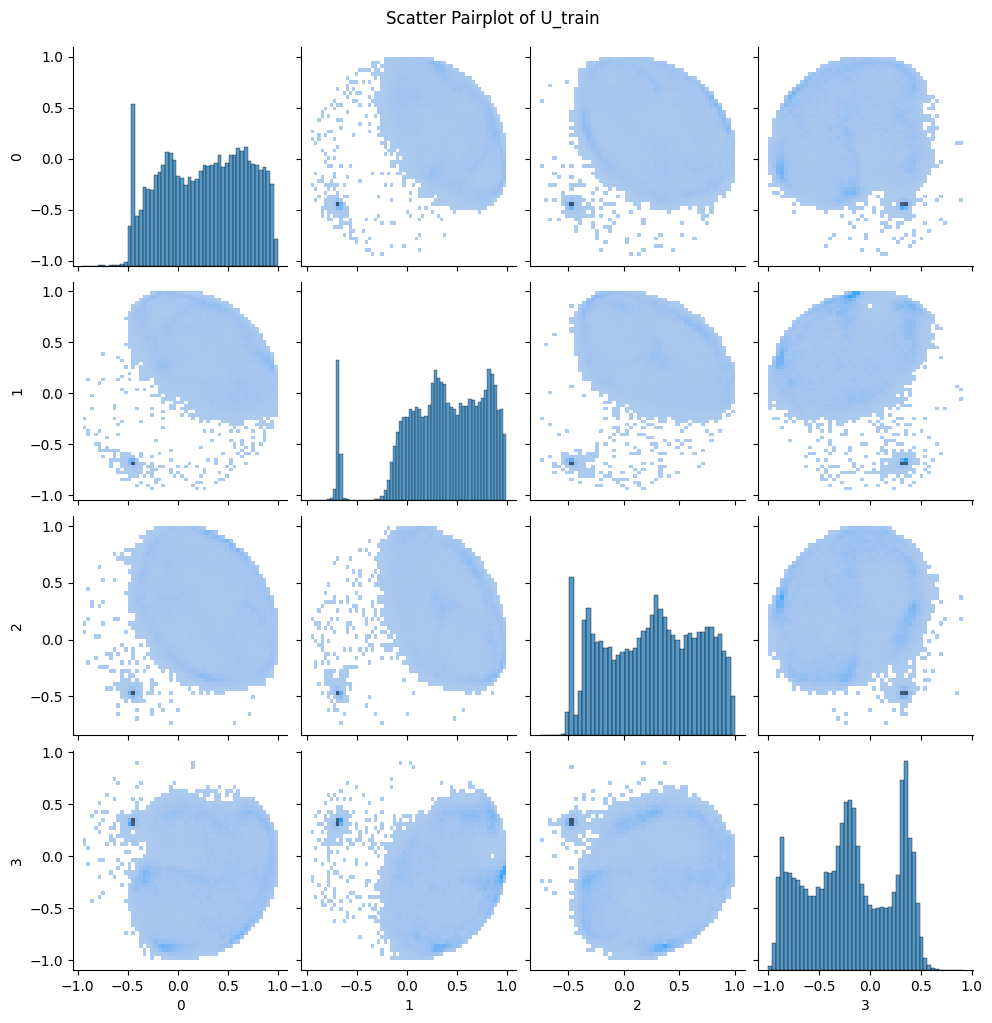

In [57]:
# Scatter pairplot of U_train
sns.pairplot(pd.DataFrame(U_train), kind="hist")
plt.suptitle('Scatter Pairplot of U_train', y=1.02)
plt.show()

In [58]:
decoder = KNNDecoder(n_neighbors=36, metric="cosine").fit(U_train, y_train)
y_pred = decoder.predict(U_test)
r2_score(y_test, y_pred)

0.06108375393383836

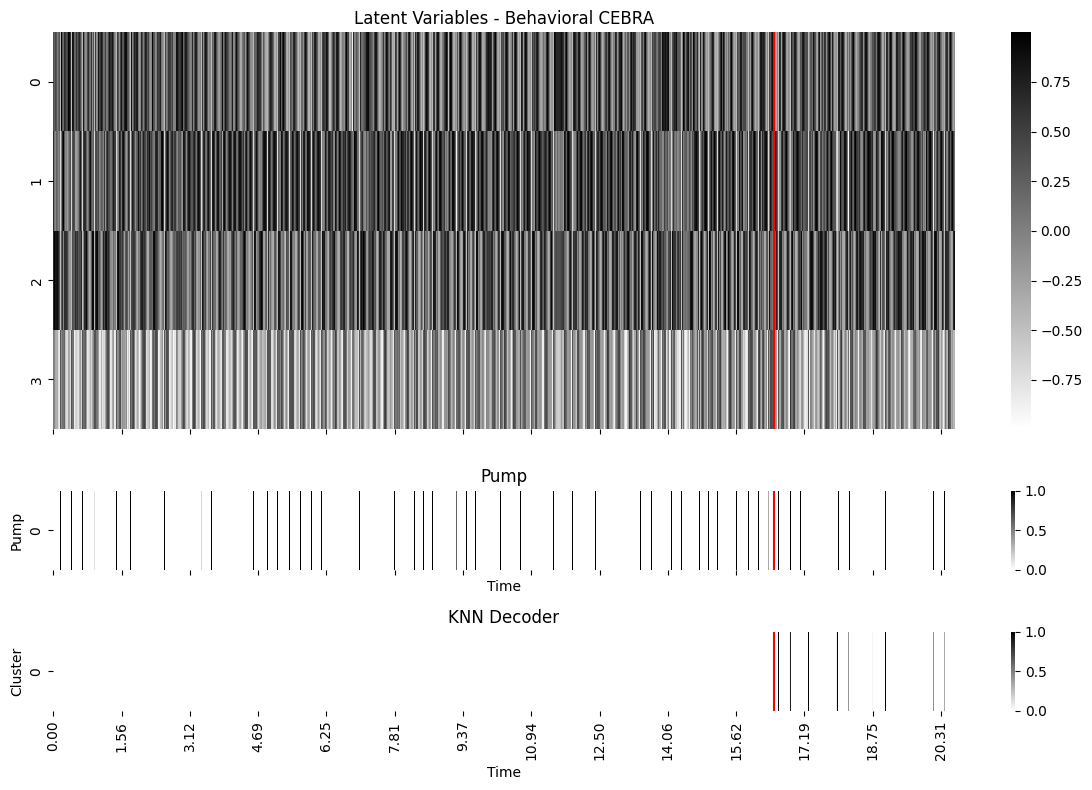

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [5, 1, 1]})

sns.heatmap(np.vstack([U_train,U_test]).T, ax=ax1, cmap='gray_r')
ax1.set_title('Latent Variables - Behavioral CEBRA')
ax1.set_xticks(x_ticks)
ax1.vlines(v_bar, 0, 16, color='red')

# Plot Pump data
sns.heatmap(df['Pump'].values.reshape(1, -1), ax=ax2, cmap='gray_r')
ax2.set_xlabel('Time')
ax2.set_ylabel('Pump')
ax2.set_title('Pump')
ax2.vlines(v_bar, 0, 1, color='red')
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels)

#Plot Kmeans classification over time
sns.heatmap(np.hstack([np.zeros(y_train.shape[0]), y_pred]).reshape(1,-1), ax=ax3, cmap='gray_r')
ax3.set_xlabel('Time')
ax3.set_ylabel('Cluster')
ax3.set_title('KNN Decoder')
ax3.vlines(v_bar, 0, 1, color='red')
ax3.set_xticks(x_ticks)
ax3.set_xticklabels(x_tick_labels)

plt.tight_layout()
plt.show()